# Grid Constraints

The limiting factor for the size of problem that can be solved with the brute-force grid approach used here is typically the memory available to store the large likelihood and posterior arrays within the `ExperimentDesigner` class.

In some problems, the full grid over some subset of variables (parameters, features or designs) is either redundant (e.g. because of some symmetry) or else the allowed combinations are limited by some constraint (e.g. `x**2 + y**2 < r**2`).

A common situation where is applies is when the likelihood $P(D \mid \theta, d)$ is invariant under permutations of some variables contained within the data features $D$, the parameters $\theta$ or the designs $d$. For example, if $x_1$ and $x_2$ are indistinguishable then we can require that $x_1 \le x_2$, without any loss of generality, and thereby reduce the size of the $(x_1,x_2)$ grid by roughly a factor of 2, and correspondingly reduce the size of the likelihood and posterior arrays by the same factor.

The examples below are all based on the sine-wave problem. For an introduction to this problem see [here](https://observablehq.com/@dkirkby/boed) and [here](https://github.com/dkirkby/bayesdesign/blob/main/examples/SineWave.ipynb).

We use the same measurement error $\sigma_y = 0.1$ throughout this noteboook:

In [1]:
sigma_y = 0.1

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from bed.grid import Grid, GridStack, PermutationInvariant
from bed.design import ExperimentDesigner

## 1. Design Grid Constraints

To demonstrate how grid constraints are implemented in the `bayesdesign` package, we revisit the [sine wave problem](https://observablehq.com/@dkirkby/boed) but now consider an experiment to consist of a pair of measurements $y_1, y_2$ made at times $t_1, t_2$. Since the order of the measurements taken at $t_1$ and $t_2$ does not affect the final result, we can require that $t_1 \le t_2$ in order to reduce the design grid size. Note we could have equally well required that $y_1 \le y_2$ (but we cannot apply both of these constraints simultaneously).

The grids and designer created in this section use the suffix "1".

### Reference Solution

We first solve this problem without any design grid constraints, as a straightforward generalization of the single-measurement example:

In [4]:
designs1 = Grid(t1=np.linspace(0, 5, 35), t2=np.linspace(0, 5, 35))

In [5]:
features1 = Grid(y1=np.linspace(-1.25, 1.25, 50), y2=np.linspace(-1.25, 1.25, 50))

In [6]:
params1 = Grid(amplitude=1, frequency=np.linspace(0.2, 2.0, 181), offset=0)

In [7]:
with GridStack(features1, designs1, params1):
    y1_mean = params1.amplitude * np.sin(params1.frequency * (designs1.t1 - params1.offset))
    y1_diff = features1.y1 - y1_mean
    y2_mean = params1.amplitude * np.sin(params1.frequency * (designs1.t2 - params1.offset))
    y2_diff = features1.y2 - y2_mean
    likelihood1 = np.exp(-0.5 * (y1_diff / sigma_y) ** 2) * np.exp(-0.5 * (y2_diff / sigma_y) ** 2)
    features1.normalize(likelihood1)

In [8]:
designer1 = ExperimentDesigner(params1, features1, designs1, likelihood1)

In [9]:
prior1 = np.ones(params1.shape)
params1.normalize(prior1);

In [10]:
best1 = designer1.calculateEIG(prior1)
designer1.describe()

GRID       designs [35:t1, 35:t2]
GRID      features [50:y1, 50:y2]
GRID    parameters [1:amplitude, 181:frequency, 1:offset]
ARRAY        prior (1, 181, 1)                0.0 Mb
ARRAY   likelihood (50, 50, 35, 35, 1, 181, 1)  4229.1 Mb
ARRAY    posterior (50, 50, 35, 35, 1, 181, 1)  4229.1 Mb
ARRAY     marginal (50, 50, 35, 35)          23.4 Mb
ARRAY           IG (50, 50, 35, 35)          23.4 Mb
ARRAY          EIG (35, 35)                   0.0 Mb


Note that the likelihood and posterior arrays are each about 4.2 Gb in size.

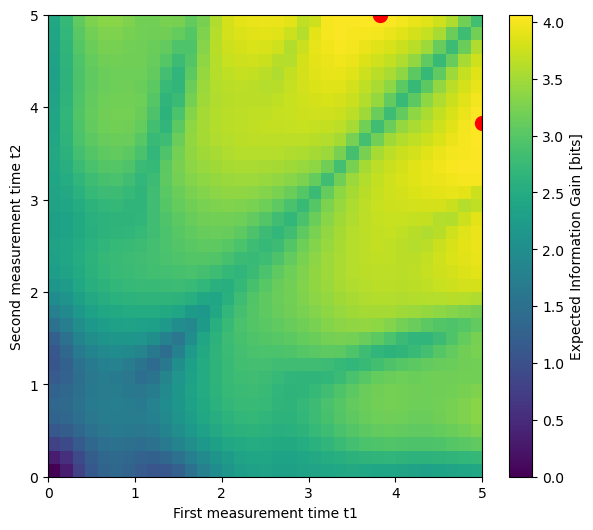

In [11]:
fig, ax = plt.subplots(figsize=(7,6))
I = ax.imshow(designer1.EIG.T, origin='lower', extent=designs1.extent('t1')+designs1.extent('t2'), aspect='auto')
plt.colorbar(I, ax=ax, label='Expected Information Gain [bits]')
ax.plot([best1['t1'], best1['t2']], [best1['t2'], best1['t1']], 'ro', markersize=10)
ax.set(xlabel='First measurement time t1', ylabel='Second measurement time t2');

A plot of the EIG versus the two measurement times shows that:
 - EIG is symmetric under the exchange of $t_1$ and $t_2$, as expected.
 - EIG is generally lower along the diagonal, since repeating a measurement at the same time is not optimal.
 - The maximum EIG of about 4 bits occurs for $t_1 = 3.82$ and $t_2 = 5.00$ (or with these swapped).

Compare a plot of the diagonal of this 2D EIG plot with the EIG for a single measurement from the SineWave notebook. They have essentially the same shape but information values are higher along the diagonal by about 0.4 bits since repeating a measurement at the same time does still provide some information due to the error of the measurement process (set by $\sigma_y = 0.1$ in this example).

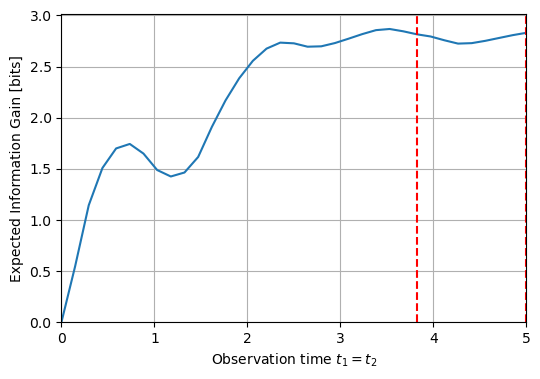

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(designs1.t1, np.diag(designer1.EIG))
ax.set(xlabel='Observation time $t_1=t_2$', xlim=designs1.extent('t1'),
       ylabel='Expected Information Gain [bits]', ylim=(0, None))
ax.axvline(best1['t1'], color='r', linestyle='--')
ax.axvline(best1['t2'], color='r', linestyle='--')
ax.grid();

### Solution with Constrained Design Space

Next, impose permutation symmetry on the design space by requiring that $t_1 \le t_2$. We only need to redefine the features grid to accomplish this, by including the optional `constraint` argument. The value of `constraint` should be a function whose arguments specify which axes the constraint applies to (typically accomplished with a `lambda` function) and which returns a positive weight associated with each combination of axis values that should be included in the grid. These weights are used when summing (or normalizing) over a grid, to ensure that the constrained grid sum matches the unconstrainted grid sum.

When the constraint is that some axes are permutation invariant, the appropriate weights are:
$$
\omega(n_0,n_1,n_2\ldots) = \frac{N!}{n_0! n_1! n_2! \ldots}
$$
where $N = \sum_k n_k$ and $n_k$ is the number of times that the $k$-th grid point is repeated. The `grid.PermutationInvariant` helper function evaluates these weights for you. Any point in the grid with a weight of zero is eliminated, thus reducing the size of the likelihood and posterior arrays. If only weights of zero and one are required, the `constraint` function can return `False/True` values that will be converted to 0/1.

In this section, we use the suffix "1b" for anything that needs to be redefined relative to the previous section.

In [13]:
designs1b = Grid(t1=np.linspace(0, 5, 35), t2=np.linspace(0, 5, 35), constraint=lambda t1,t2: PermutationInvariant(t1, t2))

If we compare the shapes of the full and constrained features grid, we see that it is about a factor of 2 smaller:

In [14]:
designs1.shape, designs1b.shape

((35, 35), (630, 1))

We can use exactly the same code to calculate the likelihood, but just replacing `designs1` with `designs1b`:

In [15]:
sigma_y=0.1
with GridStack(features1, designs1b, params1):
    y1_mean = params1.amplitude * np.sin(params1.frequency * (designs1b.t1 - params1.offset))
    y1_diff = features1.y1 - y1_mean
    y2_mean = params1.amplitude * np.sin(params1.frequency * (designs1b.t2 - params1.offset))
    y2_diff = features1.y2 - y2_mean
    likelihood1b = np.exp(-0.5 * (y1_diff / sigma_y) ** 2) * np.exp(-0.5 * (y2_diff / sigma_y) ** 2)
    features1.normalize(likelihood1b)

Run the EIG calculation with this constrained grid:

In [16]:
designer1b = ExperimentDesigner(params1, features1, designs1b, likelihood1b)

Note how the `likelihood` and `posterior` arrays are now about half the size:

In [17]:
best1b = designer1b.calculateEIG(prior1)
designer1b.describe()

GRID       designs [630:t1, 630:t2]
GRID      features [50:y1, 50:y2]
GRID    parameters [1:amplitude, 181:frequency, 1:offset]
ARRAY        prior (1, 181, 1)                0.0 Mb
ARRAY   likelihood (50, 50, 630, 1, 1, 181, 1)  2174.9 Mb
ARRAY    posterior (50, 50, 630, 1, 1, 181, 1)  2174.9 Mb
ARRAY     marginal (50, 50, 630, 1)          12.0 Mb
ARRAY           IG (50, 50, 630, 1)          12.0 Mb
ARRAY          EIG (630, 1)                   0.0 Mb


In [18]:
assert best1 == best1b

Expand this constrained EIG to the full shape of the unconstrained EIG for comparison, using the `expand` method. Values that were eliminated from the grid due to the permutation symmetry will be `np.nan`.

In [19]:
EIG1b = designs1b.expand(designer1b.EIG)

Plot the expanded EIG and verify that it matches the plot above in the upper-triangular region where $t_1 \le t_2$:

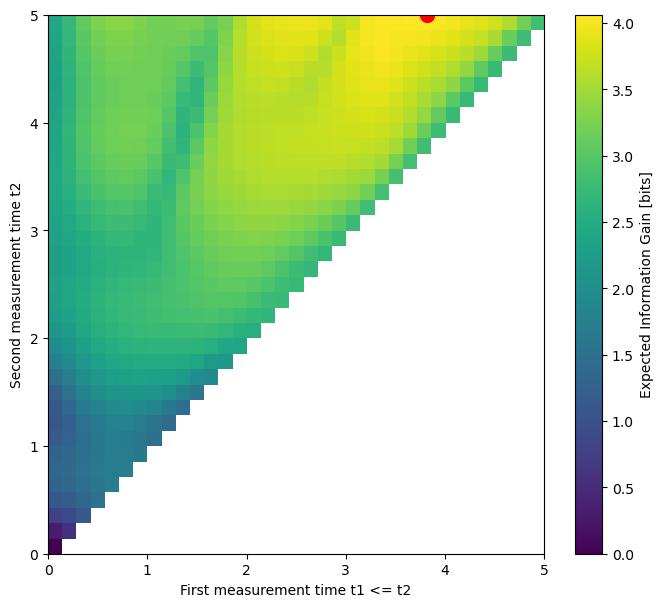

In [20]:
fig, ax = plt.subplots(figsize=(8,7))
I = ax.imshow(EIG1b.T, origin='lower', extent=designs1b.extent('t1')+designs1b.extent('t2'), aspect='auto')
plt.colorbar(I, ax=ax, label='Expected Information Gain [bits]')
ax.plot(best1b['t1'], best1b['t2'], 'ro', markersize=10)
ax.set(xlabel='First measurement time t1 <= t2', ylabel='Second measurement time t2');

The two calculations are identical on the subset of distinguishable grid points specified by the constraint:

In [21]:
mask = ~np.isnan(EIG1b)
assert np.array_equal(designer1.EIG[mask], EIG1b[mask])

## 2. Parameter Grid Constraints

Next, we consider constraints on a parameter grid. The key difference from a design grid constraint is that the posterior probability density (which the EIG calculation uses) is normalized over the space of all possible parameters. We consider a generalization of the sine-wave problem where there are now two sine waves of different frequencies, $f_1$ and $f_2$, but the same amplitude and offset. The two frequencies are therefore indistinguishable so we can require that $f_1 \le f_2$ to reduce the grid size.

The grids and designer created in this section use the suffix "2".

### Reference Solution

We first solve this problem without any parameter grid constraint.

In [22]:
designs2 = Grid(t_obs=np.linspace(0, 5, 101))

In [23]:
features2 = Grid(y_obs=np.linspace(-1.25, 1.25, 100))

In [24]:
params2 = Grid(amplitude=1, f1=np.linspace(0.2, 2.0, 181), f2=np.linspace(0.2, 2.0, 181), offset=0)

In [25]:
with GridStack(features2, designs2, params2):
    y_mean = params2.amplitude * (
        np.sin(params2.f1 * (designs2.t_obs - params2.offset)) +
        np.sin(params2.f2 * (designs2.t_obs - params2.offset)))
    y_diff = features2.y_obs - y_mean
    likelihood2 = np.exp(-0.5 * (y_diff / sigma_y) ** 2)
    features2.normalize(likelihood2)

In [26]:
designer2 = ExperimentDesigner(params2, features2, designs2, likelihood2)

In [27]:
prior2 = np.ones(params2.shape)
params2.normalize(prior2);

In [28]:
best2 = designer2.calculateEIG(prior2)
designer2.describe()

GRID       designs [101:t_obs]
GRID      features [100:y_obs]
GRID    parameters [1:amplitude, 181:f1, 181:f2, 1:offset]
ARRAY        prior (1, 181, 181, 1)           0.2 Mb
ARRAY   likelihood (100, 101, 1, 181, 181, 1)  2524.5 Mb
ARRAY    posterior (100, 101, 1, 181, 181, 1)  2524.5 Mb
ARRAY     marginal (100, 101)                 0.1 Mb
ARRAY           IG (100, 101)                 0.1 Mb
ARRAY          EIG (101,)                     0.0 Mb


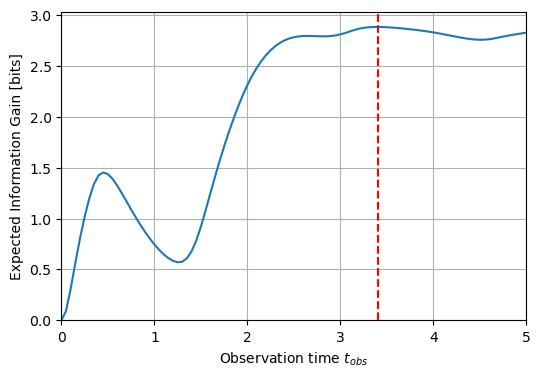

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(designs2.t_obs, designer2.EIG)
ax.set(xlabel='Observation time $t_{obs}$', xlim=designs2.extent('t_obs'),
       ylabel='Expected Information Gain [bits]', ylim=(0, None))
ax.axvline(best2['t_obs'], color='red', linestyle='--')
ax.grid();

Plot the posterior over the two frequency parameters assuming an initial measurement at the optimal $t_{obs} = 3.4$ with result $y_{obs} = -0.1$. As expected, it is symmetric in $f_1$ and $f_2$. It is also multi-modal.

In [30]:
post2 = designer2.get_posterior(t_obs=best2['t_obs'], y_obs=-0.1)

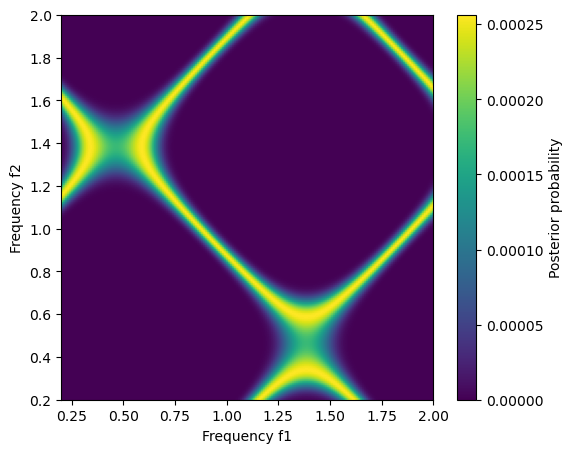

In [31]:
fig, ax = plt.subplots(figsize=(6,5))
I = ax.imshow(post2.squeeze().T, extent=params2.extent('f1')+params2.extent('f2'), origin='lower', aspect='auto')
plt.colorbar(I, ax=ax, label='Posterior probability')
ax.set(xlabel='Frequency f1', ylabel='Frequency f2');

### Solution with Constrained Parameter Space

Next, we modify the parameter grid to enforce $f_1 \le f_2$ and repeat the calculation. Use the suffix "2b" for anything that needs to be redefined.

In [32]:
params2b = Grid(amplitude=1, f1=np.linspace(0.2, 2.0, 181), f2=np.linspace(0.2, 2.0, 181), offset=0,
                constraint=lambda f1,f2: PermutationInvariant(f1, f2))

In [33]:
with GridStack(features2, designs2, params2b):
    y_mean = params2b.amplitude * (
        np.sin(params2b.f1 * (designs2.t_obs - params2b.offset)) +
        np.sin(params2b.f2 * (designs2.t_obs - params2b.offset)))
    y_diff = features2.y_obs - y_mean
    likelihood2b = np.exp(-0.5 * (y_diff / sigma_y) ** 2)
    features2.normalize(likelihood2b)

In [34]:
designer2b = ExperimentDesigner(params2b, features2, designs2, likelihood2b)

In [35]:
prior2b = np.ones(params2b.shape)
params2b.normalize(prior2b);

In [36]:
best2b = designer2b.calculateEIG(prior2b)
designer2b.describe()

GRID       designs [101:t_obs]
GRID      features [100:y_obs]
GRID    parameters [1:amplitude, 16471:f1, 16471:f2, 1:offset]
ARRAY        prior (1, 16471, 1, 1)           0.1 Mb
ARRAY   likelihood (100, 101, 1, 16471, 1, 1)  1269.2 Mb
ARRAY    posterior (100, 101, 1, 16471, 1, 1)  1269.2 Mb
ARRAY     marginal (100, 101)                 0.1 Mb
ARRAY           IG (100, 101)                 0.1 Mb
ARRAY          EIG (101,)                     0.0 Mb


In [37]:
assert best2 == best2b

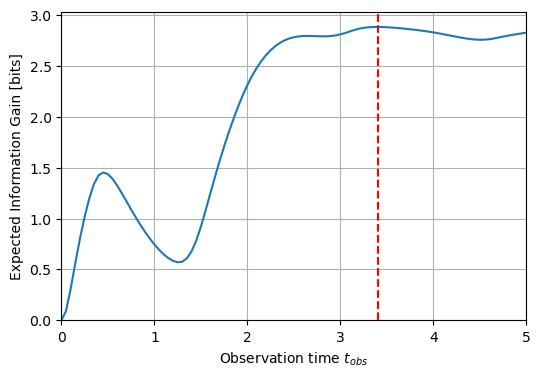

In [38]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(designs2.t_obs, designer2b.EIG)
ax.set(xlabel='Observation time $t_{obs}$', xlim=designs2.extent('t_obs'),
       ylabel='Expected Information Gain [bits]', ylim=(0, None))
ax.axvline(best2b['t_obs'], color='red', linestyle='--')
ax.grid();

Calculate the posterior in the frequencies after the measurement, to compare with the result obtained above:

In [39]:
post2b = designer2b.get_posterior(t_obs=best2b['t_obs'], y_obs=-0.1)
post2b_expanded = params2b.expand(post2b)

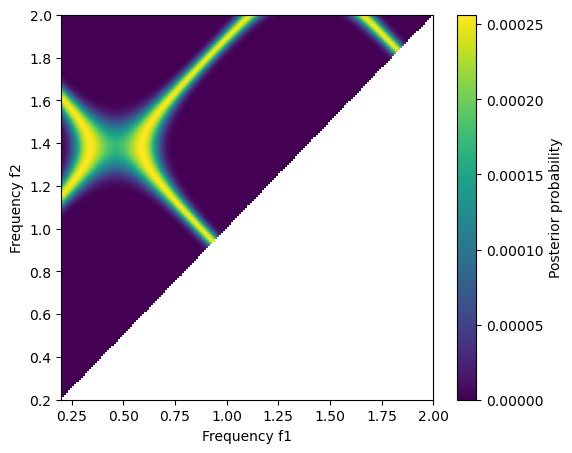

In [40]:
fig, ax = plt.subplots(figsize=(6,5))
I = ax.imshow(post2b_expanded.squeeze().T, extent=params2.extent('f1')+params2.extent('f2'), origin='lower', aspect='auto')
plt.colorbar(I, ax=ax, label='Posterior probability')
ax.set(xlabel='Frequency f1', ylabel='Frequency f2');

Compare the posterior after the measurement, calculated with and without constraints. They agree to high accuracy, although are not identical due to small differences in round-off errors due to differences in the weighted versus unweighted normalization calculation.

In [41]:
mask = ~np.isnan(post2b_expanded)
assert np.allclose(post2[mask], post2b_expanded[mask], rtol=1e-18, atol=1e-18)